In [1]:
from collaborative_filtering import run

def predict_collaborative_filtering(utility):
    return run(utility, predictions_description)



In [4]:
import numpy as np
import pandas as pd
import os.path
from collaborative_filtering import run

# Where data is located
movies_file = './data/movies.csv'
users_file = './data/users.csv'
ratings_file = './data/ratings.csv'
predictions_file = './data/predictions.csv'
submission_file = './data/submission.csv'

# Read the data using pandas
movies_description = pd.read_csv(movies_file, delimiter=';', dtype={'movieID': 'int', 'year': 'int', 'movie': 'str'},
                                 names=['movieID', 'year', 'movie'])
users_description = pd.read_csv(users_file, delimiter=';',
                                dtype={'userID': 'int', 'gender': 'str', 'age': 'int', 'profession': 'int'},
                                names=['userID', 'gender', 'age', 'profession'])
ratings_description = pd.read_csv(ratings_file, delimiter=';',
                                  dtype={'userID': 'int', 'movieID': 'int', 'rating': 'int'},
                                  names=['userID', 'movieID', 'rating'])
predictions_description = pd.read_csv(predictions_file, delimiter=';', names=['userID', 'movieID'], header=None)

utility_matrix: pd.DataFrame = \
    ratings_description.pivot(index='userID', columns='movieID', values='rating')


utility_matrix.loc[:, set(movies_description['movieID'].to_numpy().tolist()).difference(set(utility_matrix.columns.to_numpy().tolist()))] = 0
print(utility_matrix.shape)



(6040, 3706)


In [12]:
train_predictions = ratings_description[["userID", "movieID"]]

In [16]:
%%time
cf_train_predictions = dict(run(utility_matrix, train_predictions))

C:\Users\Asus\DM_Challenge\collaborative_filtering.py:97: RuntimeWarning: divide by zero encountered in true_divide
  inv_square_mag = 1 / square_mag


started prediction matrix
started prediction matrix
{1: 2.384598946110691, 2: 2.049222821786947, 3: 2.0779306060702485, 4: 2.1434689435282848, 5: 2.014229498759115, 6: 2.20412761366061, 7: 2.16459543245371, 8: 2.061517207539582, 9: 1.9596846194314264, 10: 2.036986194990999, 11: 2.252893050088597, 12: 1.849140946677238, 13: 2.1299522316221444, 14: 2.199416337893626, 15: 1.9239916300390507, 16: 2.221419719836927, 17: 2.294940132828444, 18: 2.2195009470841023, 19: 2.0045860755650398, 20: 1.9486409070826725, 21: 2.2217712719167766, 22: 2.160656692453315, 23: 2.0202342289143007, 24: 2.0588909591186932, 25: 2.3031925361697225, 26: 2.2364188583196456, 27: 2.1223120325511573, 28: 2.361459141084419, 29: 2.251076825189857, 30: 2.2758764786047654, 31: 2.1307340577336347, 32: 2.257355425894162, 33: 2.066053713629249, 34: 2.373172829885402, 35: 2.0715321670397078, 36: 2.2476349055471667, 37: 2.1537740004741663, 38: 1.9135999867899791, 39: 2.2535277035209655, 40: 2.2102906676849554, 41: 2.3005646789

         movieID
0       3.509927
1       3.423801
2       2.946372
3       3.461843
4       3.221284
...          ...
910185  2.996488
910186  3.068577
910187  3.192943
910188  3.219150
910189  3.433654

[910190 rows x 1 columns]
Wall time: 10.9 s


In [22]:
##### Construct Utility Matrix ####### 
R = np.zeros((len(movies_description), len(users_description)))

for user, movie, rating in ratings_description.values:
    R[movie-1, user-1] = rating

R[R==0] = np.nan
print(f"Shape of Utility matrix is (movies, users): {R.shape}")

#### LATENT FACTORS WITH REGULARIZATION ####
#### LATENT FACTORS HYPERPARAMETERS ####
from tqdm import tqdm_notebook as tqdm

EPOCHS = 1000
LEARNING_RATE = 0.05 # == nu
LAMBDA = 0.01
K = 2 # number of factors to work with.

np.random.seed(42)
Q = np.random.uniform(-1, 1, (R.shape[0], K))
P = np.random.uniform(-1, 1, (K, R.shape[1]))
div = (R.shape[0] * R.shape[1]) - np.isnan(R).sum()
RMSE = np.sqrt(((np.nan_to_num(R - np.matmul(Q, P), 0)**2).sum())/div)
print(f"Starting RMSE: {RMSE}")

objectives = []

for epoch in tqdm(range(1000)):
    R_pred = np.matmul(Q,P)
    curr_error = np.nan_to_num(R - R_pred, 0)
    Q_update = np.zeros(Q.shape)
    for i in range(len(Q_update)):
        for curr_k in range(K):
            Q_delta =(-2 * np.dot(P[curr_k, :], curr_error[i]))/np.isnan(R[i]).sum()
            Q_update[i, curr_k] = LEARNING_RATE * (Q_delta + LAMBDA*Q[i, curr_k])

    P_update = np.zeros(P.shape)
    for i in range(P_update.shape[1]):
        for curr_k in range(K):
            P_delta =(-2 * np.dot(Q[:, curr_k], curr_error[:, i]))/np.isnan(R[:, i]).sum()
            P_update[curr_k, i] = LEARNING_RATE * (P_delta + LAMBDA*P[curr_k, i])

    Q -= Q_update
    P -= P_update
    
    RMSE_i = np.sqrt(((np.nan_to_num(R - np.matmul(Q, P), 0)**2).sum())/div)
    print(f"RMSE {epoch}: {RMSE_i}")
    objectives.append([epoch, RMSE_i])


RMSE = np.sqrt(((np.nan_to_num(R - np.matmul(Q, P), 0)**2).sum())/div)
print(f"Final RMSE: {RMSE}")

Shape of Utility matrix is (movies, users): (3706, 6040)
Starting RMSE: 3.781830053581588


<ipython-input-22-db8f8eea5586>:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(1000)):


RMSE 0: 3.7810569863061056
RMSE 1: 3.7803143482127624
RMSE 2: 3.779600254864564
RMSE 3: 3.7789129704709286
RMSE 4: 3.778250893695214
RMSE 5: 3.777612544956513
RMSE 6: 3.7769965550515123
RMSE 7: 3.7764016549438972
RMSE 8: 3.775826666587716
RMSE 9: 3.7752704946672684
RMSE 10: 3.7747321191502476
RMSE 11: 3.7742105885634096
RMSE 12: 3.7737050139101416
RMSE 13: 3.7732145631594074
RMSE 14: 3.7727384562430437
RMSE 15: 3.7722759605057528
RMSE 16: 3.7718263865583967
RMSE 17: 3.7713890844906057
RMSE 18: 3.7709634404033237
RMSE 19: 3.770548873226374
RMSE 20: 3.7701448317896378
RMSE 21: 3.7697507921195914
RMSE 22: 3.769366254935952
RMSE 23: 3.7689907433255794
RMSE 24: 3.7686238005728576
RMSE 25: 3.7682649881278585
RMSE 26: 3.7679138836952064
RMSE 27: 3.767570079427781
RMSE 28: 3.767233180211209
RMSE 29: 3.7669028020254043
RMSE 30: 3.7665785703712467
RMSE 31: 3.766260118750528
RMSE 32: 3.765947087188441
RMSE 33: 3.7656391207883746
RMSE 34: 3.7653358683090308
RMSE 35: 3.7650369807546875
RMSE 36: 3.7

RMSE 290: 1.3591045088586962
RMSE 291: 1.3557129118222715
RMSE 292: 1.3523605188838517
RMSE 293: 1.3490467232823815
RMSE 294: 1.3457709300497775
RMSE 295: 1.342532555739377
RMSE 296: 1.339331028161372
RMSE 297: 1.336165786125044
RMSE 298: 1.333036279187646
RMSE 299: 1.329941967409705
RMSE 300: 1.3268823211166212
RMSE 301: 1.3238568206663381
RMSE 302: 1.3208649562229728
RMSE 303: 1.3179062275362
RMSE 304: 1.3149801437262567
RMSE 305: 1.312086223074425
RMSE 306: 1.309223992818795
RMSE 307: 1.3063929889552262
RMSE 308: 1.3035927560433156
RMSE 309: 1.30082284701728
RMSE 310: 1.2980828230015713
RMSE 311: 1.2953722531311314
RMSE 312: 1.2926907143761444
RMSE 313: 1.2900377913711794
RMSE 314: 1.2874130762485765
RMSE 315: 1.2848161684759838
RMSE 316: 1.2822466746979309
RMSE 317: 1.279704208581327
RMSE 318: 1.2771883906647579
RMSE 319: 1.2746988482115058
RMSE 320: 1.2722352150662015
RMSE 321: 1.269797131514943
RMSE 322: 1.2673842441488905
RMSE 323: 1.2649962057311337
RMSE 324: 1.262632675066859


RMSE 576: 1.0190555055352626
RMSE 577: 1.0186999756985025
RMSE 578: 1.0183464533090778
RMSE 579: 1.0179949235977894
RMSE 580: 1.017645371928985
RMSE 581: 1.0172977837991253
RMSE 582: 1.0169521448353587
RMSE 583: 1.016608440794124
RMSE 584: 1.0162666575597674
RMSE 585: 1.0159267811431685
RMSE 586: 1.0155887976804001
RMSE 587: 1.0152526934313884
RMSE 588: 1.0149184547785972
RMSE 589: 1.014586068225731
RMSE 590: 1.0142555203964472
RMSE 591: 1.0139267980330913
RMSE 592: 1.0135998879954375
RMSE 593: 1.0132747772594608
RMSE 594: 1.0129514529161057
RMSE 595: 1.0126299021700846
RMSE 596: 1.0123101123386886
RMSE 597: 1.0119920708505965
RMSE 598: 1.0116757652447248
RMSE 599: 1.0113611831690712
RMSE 600: 1.0110483123795848
RMSE 601: 1.0107371407390344
RMSE 602: 1.0104276562159116
RMSE 603: 1.010119846883326
RMSE 604: 1.0098137009179349
RMSE 605: 1.009509206598861
RMSE 606: 1.0092063523066515
RMSE 607: 1.0089051265222189
RMSE 608: 1.008605517825825
RMSE 609: 1.0083075148960512
RMSE 610: 1.00801110

KeyboardInterrupt: 

In [26]:
#### CREATE SUBMISSION ####
lf_train_predictions = []
for i, [user,movie, rating] in enumerate(ratings_description.values):
    lf_train_predictions.append([i+1, R_pred[movie-1,user-1]])

In [39]:
labels = ratings_description.values[:, -1]
lf_train = np.array(lf_train_predictions)

cf_train = np.array([[k,v] for k, v in cf_train_predictions.items()])

In [43]:
def rmse(actual, predicted):
    return np.sqrt(((actual-predicted)**2).sum()/len(actual))

In [50]:
pred_curve = []
for a in np.arange(0.0, 1.0, 0.01):
    tmp_predictions = a*lf_train[:, -1] + (1-a)*cf_train[:, -1]
    pred_curve.append([a, rmse(labels, tmp_predictions)])
pred_curve = np.array(pred_curve)

In [51]:
pred_curve

array([[0.        , 1.12099404],
       [0.01      , 1.11735048],
       [0.02      , 1.11374296],
       [0.03      , 1.11017184],
       [0.04      , 1.10663747],
       [0.05      , 1.1031402 ],
       [0.06      , 1.09968038],
       [0.07      , 1.09625838],
       [0.08      , 1.09287454],
       [0.09      , 1.08952922],
       [0.1       , 1.08622278],
       [0.11      , 1.08295557],
       [0.12      , 1.07972796],
       [0.13      , 1.07654028],
       [0.14      , 1.07339291],
       [0.15      , 1.0702862 ],
       [0.16      , 1.0672205 ],
       [0.17      , 1.06419617],
       [0.18      , 1.06121355],
       [0.19      , 1.05827301],
       [0.2       , 1.05537489],
       [0.21      , 1.05251955],
       [0.22      , 1.04970733],
       [0.23      , 1.04693859],
       [0.24      , 1.04421366],
       [0.25      , 1.04153289],
       [0.26      , 1.03889663],
       [0.27      , 1.03630521],
       [0.28      , 1.03375897],
       [0.29      , 1.03125824],
       [0.

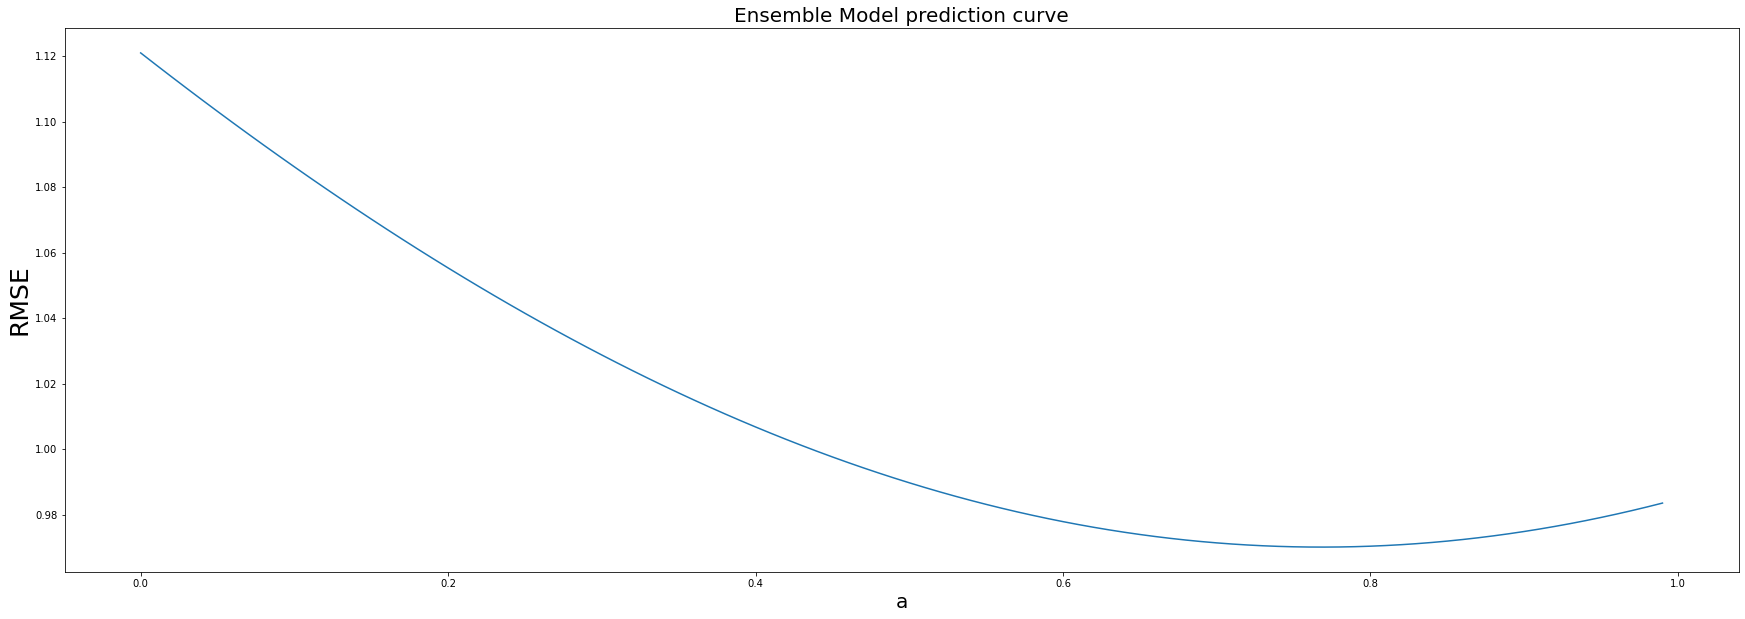

In [52]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 10))
plt.title("Ensemble Model prediction curve", fontsize=20)
plt.xlabel("a", fontsize=20)
plt.ylabel("RMSE", fontsize=25)
plt.plot(pred_curve[:, 0], pred_curve[:, 1])      